# Run atoti experiment
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/01-use-cases/other-industries/object-detection/main.ipynb)._]

faceNet: full path to the parent directory where face detection model is stored
maskNet: full path to the masked face classifier, including the model file
conf_level: minimum probability to filter weak detections from the faceNet model
video_from_camera: full path to the video recording associated to a specific camera
output_folder: folder where the predictions are stored in csv files

__NOTE__: This notebook showcases how we can integrate deep learning outcome into atoti. 
The last used opencv-python version is `4.4.0.46` and it is not maintained towards the newer versions.

In [1]:
# some references
# https://github.com/CSSEGISandData/COVID-19
# https://www.pnas.org/content/118/4/e2014564118
# Risk calculator: https://www.mpic.de/4747361/risk-calculator?en

### Load librairies

In [2]:
# unable to add detectron2 as dependencies in pyproject.toml with poetry. Therefore, uncomment the below and install the dependencies if you haven't installed them.
# ! pip install torch torchvision opencv-python

# run the below command in the terminal to install detectron2
## pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Using Deep learning and atoti to predict spread of Covid 19



In [3]:
import os
import sys
import time

import atoti as tt
import pandas as pd
from ai import detect_masked_face_from_video as detector_object
from IPython.display import clear_output
from watchdog.events import FileCreatedEvent, FileSystemEventHandler
from watchdog.observers.polling import PollingObserver
from datetime import datetime

# supress warnings
import warnings

warnings.filterwarnings("ignore")

## STEP 0: Define variables

In [4]:
print(os.getcwd())

base_path = os.getcwd()

masked_face_detector = os.path.join(base_path, "ai", "model", "model_final.pth")
conf_level = 0.5

output_folder = os.path.join(base_path, "data", "output_files")

metadata_folder = os.path.join(base_path, "data", "metadata")

broadcast_dict = {}

C:\Users\Yeo Hui Fang\Documents\GitHub\notebooks-6\notebooks\object-detection


## STEP 1: Create atoti mask monitoring system

In [5]:
def sound_alert(location, video_id):
    global broadcast_dict

    last_broadcast = broadcast_dict[video_id]
    time_diff_seconds = (datetime.now() - last_broadcast).total_seconds()
    print(
        f"last broadcast timing: {last_broadcast} - Time from last broadcast: {time_diff_seconds}."
    )

    if time_diff_seconds > 15:
        mask_alert_df = cube.query(
            m["mask alert"],
            m["Incidence Rate"],
            m["Event risk"],
            m["Unmasked proportion"],
            levels=[l["video_id"], l["location"], l["quarter_timestamp"]],
            condition=((l["location"] == location) & (l["video_id"] == video_id)),
        )

        mask_alert_df.reset_index(inplace=True)
        alert_dtl = mask_alert_df.iloc[-1]

        print(
            "--------- Mask alert",
            alert_dtl["mask alert"],
            " last screened time: ",
            alert_dtl["quarter_timestamp"],
        )
        if alert_dtl["mask alert"] == True:

            qtr_ts = alert_dtl["quarter_timestamp"]
            incidence_rate = alert_dtl["Incidence Rate"]
            event_risk = alert_dtl["Event risk"]
            unmasked_prop = alert_dtl["Unmasked proportion"]

            print(
                "==============================================================================================="
            )
            print(
                f"last_broadcast: {last_broadcast}, location: {location}, video_id: {video_id}"
            )
            print(
                f"quarter_timestamp: {qtr_ts}, incident rate: {incidence_rate}, event risk: {event_risk}, unmasked proportion: {unmasked_prop}"
            )
            print(
                "==============================================================================================="
            )

            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
            print("@@@@@@@@@@@@@@@@@@@ SOUNDING ALERT @@@@@@@@@@@@@@@@@@@")
            print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
            os.system("mask_alert.m4a")
            broadcast_dict[video_id] = datetime.now()

In [6]:
def get_video_dtl(filename):
    print("get_video_dtl: ", filename)
    name_wo_extention = filename.split(".")[0]

    return name_wo_extention.split("_")

### Création d'une sesssion atoti 

In [7]:
session = tt.Session(user_content_storage="./content")

### Create an empty table for the mask detections

In [8]:
mask_detection_tbl = session.read_csv(
    "data/output_files/*.csv",
    table_name="mask_detection",
    types={
        "predictions": tt.type.FLOAT,
        "label": tt.type.STRING,
        "video_id": tt.type.STRING,
        "face_id": tt.type.INT,
        "timestamp": tt.type.LOCAL_DATE_TIME,
        "quarter_timestamp": tt.type.LOCAL_DATE_TIME,
    },
    date_patterns={
        "timestamp": "YYYY-MM-dd HH:mm:ss:SSSSSS",
        "quarter_timestamp": "YYYY-MM-dd HH:mm:ss",
    },
    keys=["video_id", "face_id", "timestamp"],
    partitioning="hash32(face_id)",
)

In [9]:
mask_detection_tbl.head()

,,,predictions,label,quarter_timestamp
face_id,timestamp,video_id,,,
30,2022-08-19 11:21:22.243530,camera1,97.89333,No Mask,2022-08-19 11:21:25
57,2022-08-19 11:21:23.133433,camera1,99.80121,No Mask,2022-08-19 11:21:25
89,2022-08-19 11:21:24.088446,camera1,86.14429,No Mask,2022-08-19 11:21:25
125,2022-08-19 11:21:25.139989,camera1,98.89994,Mask,2022-08-19 11:21:30
30,2022-08-19 11:21:26.412504,camera1,98.23522,Mask,2022-08-19 11:21:30


In [10]:
# get location and video_id from source filename
files = os.listdir("data/output_files")
file_list = [get_video_dtl(f) for f in files if "csv" in f]
video_df = pd.DataFrame(file_list, columns=["location", "video_id"])

get_video_dtl:  Paris_camera1.csv


In [11]:
file_list

[['Paris', 'camera1']]

In [12]:
video_id_tbl = session.read_pandas(
    video_df,
    table_name="video_id",
    types={"video_id": tt.type.STRING, "location": tt.type.STRING},
)

In [13]:
video_id_tbl.head()

,location,video_id
0,Paris,camera1


In [14]:
# https://www.data.gouv.fr/fr/datasets/synthese-des-indicateurs-de-suivi-de-lepidemie-covid-19/
covid_stats = session.read_csv(
    "data/table-indicateurs-open-data-dep-2021-09-23-trimmed.csv",
    table_name="covid_stats",
    keys=["lib_dep"],
    types={"dep": tt.type.STRING},
    process_quotes=True,
)
covid_stats.head()

,dep,date,reg,lib_reg,tx_pos,tx_incid,TO,R,hosp,rea,...,dchosp,reg_rea,incid_hosp,incid_rea,incid_rad,incid_dchosp,reg_incid_rea,pos,pos_7j,cv_dose1
lib_dep,,,,,,,,,,,,,,,,,,,,,
Haute-Savoie,74,9/20/2021,84,Auvergne et Rhône-Alpes,1.441349,71.583344,0.271914,NaN,65,14,...,1065,152,5,1,0,0,11,134,593,N/A
Haute-Vienne,87,9/20/2021,75,Nouvelle Aquitaine,1.495743,52.592684,0.230583,NaN,34,7,...,335,95,2,1,0,1,4,42,195,N/A
Gironde,33,9/20/2021,75,Nouvelle Aquitaine,1.329090,55.220884,0.230583,NaN,168,47,...,1137,95,7,3,2,2,4,174,902,N/A
Loire,42,9/20/2021,84,Auvergne et Rhône-Alpes,1.262048,54.790078,0.271914,NaN,87,10,...,1410,152,3,0,2,2,11,70,419,N/A
Meuse,55,9/20/2021,44,Grand Est,0.752823,29.728971,0.215054,NaN,3,0,...,382,100,2,0,1,0,9,8,54,N/A


### Jointure des tables

In [15]:
mask_detection_tbl.join(video_id_tbl, mapping={"video_id": "video_id"})
video_id_tbl.join(covid_stats, mapping={"location": "lib_dep"})

### Creation d'un cube atoti

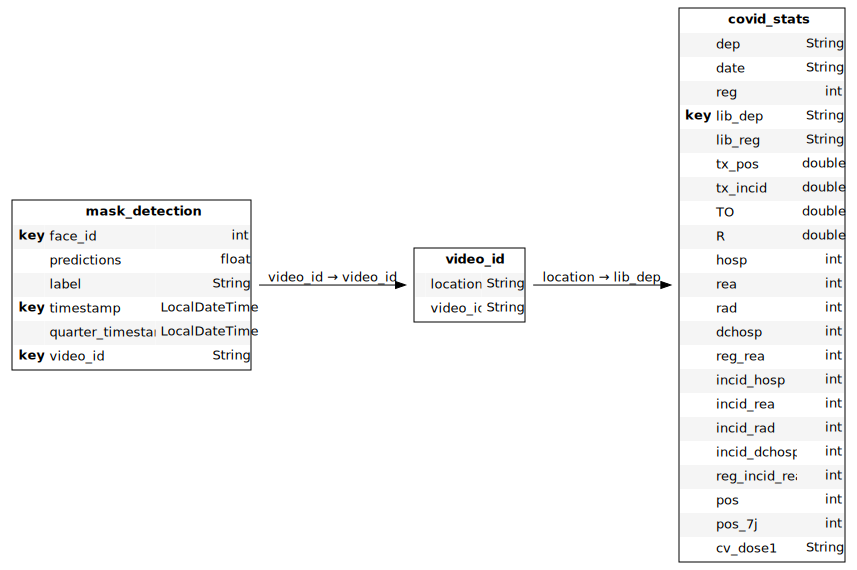

In [16]:
cube = session.create_cube(mask_detection_tbl, "mask_detection_system")
cube.schema

In [17]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### Criteria and triggers for alerting

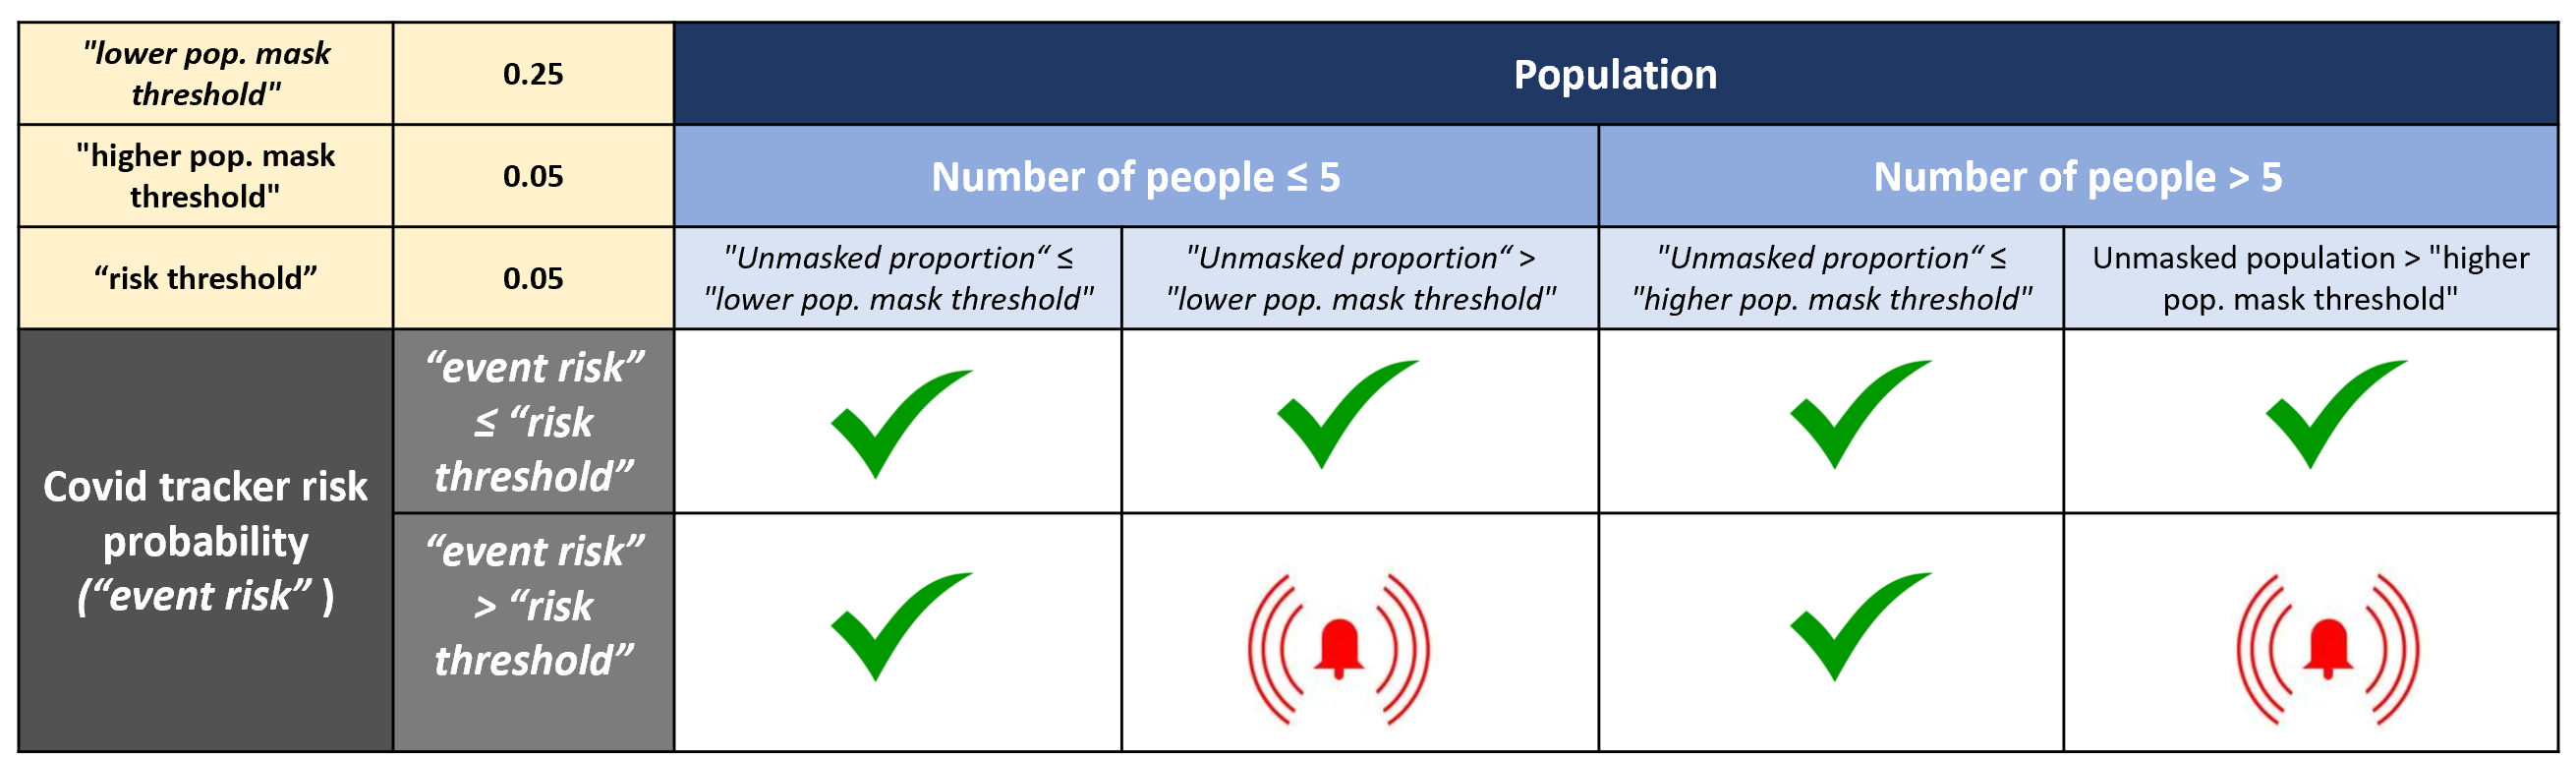

In [18]:
### filter away the contribution where no faces were captured
_populated_count = tt.filter(m["contributors.COUNT"], l["label"] == "N/A")

m["Total population"] = (
    tt.agg.mean(
        tt.parent_value(m["contributors.COUNT"], degrees={h["label"]: 1}),
        scope=tt.OriginScope(l["label"]),
    )
    - _populated_count
)

In [19]:
session.visualize("Masked trends")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [20]:
m["Unmasked count"] = tt.filter(m["contributors.COUNT"], l["label"] == "No Mask")

In [21]:
m["Unmasked proportion"] = m["Unmasked count"] / m["Total population"]
m["Unmasked proportion"].formatter = "DOUBLE[#.000%]"

In [22]:
session.visualize("Unmasked population for camera 1")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [23]:
session.visualize("Time where unmasked population detected")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [26]:
m["Incidence Rate"] = tt.where(
    l["location"] == None, tt.agg.single_value(covid_stats["tx_incid"])
)

In [27]:
pop_rate_denom = 100000
m["Event risk"] = (
    1 - (1 - (m["Incidence Rate"] / pop_rate_denom * 2)) ** m["Total population"]
)
m["Event risk"].formatter = "DOUBLE[#.000%]"

In [28]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [29]:
# if population is <= 5, at most 25% population can be unmasked.
# if population is >5, at most 5% of population can be unmasked.
threshold_simulation = cube.create_parameter_simulation(
    "Threshold simulation",
    measures={
        "risk threshold": 0.05,
        "lower pop. size": 5,
        "lower pop. mask threshold": 0.25,
        "higher pop. mask threshold": 0.05,
    },
)

In [30]:
m["risk alert"] = tt.where(m["Event risk"] > m["risk threshold"], True, False)

In [31]:
m["mask threshold"] = tt.where(
    m["contributors.COUNT"] <= m["lower pop. size"],
    m["lower pop. mask threshold"],
    m["higher pop. mask threshold"],
)

In [32]:
m["unmasked population alert"] = tt.where(
    m["Unmasked proportion"] > m["mask threshold"], True, False
)

In [33]:
m["mask alert"] = tt.where(
    (m["risk alert"] == True) & (m["Unmasked proportion"] > m["mask threshold"]),
    True,
    False,
)

In [34]:
m["risk threshold"].formatter = "DOUBLE[#.000%]"

In [35]:
session.visualize("Mask alert with relevance to event risk")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### Use watchdog to monitor folder for incoming files or modified file

In [36]:
dir_name = "data/output_files/"


class AtotiWatcher(FileSystemEventHandler):
    global broadcast_dict

    def load_mask_detection(self, src_path, filename):
        mask_detection_tbl.load_csv(
            src_path,
            date_patterns={"timestamp": "YYYY-MM-dd HH:mm:ss:SSSSSS"},
        )
        print("File loaded into mask detection table", src_path)

        name_tokens = get_video_dtl(filename)

        return pd.DataFrame(
            data={
                "location": [name_tokens[0]],
                "video_id": [name_tokens[1]],
            }
        )

    def on_created(self, event: FileCreatedEvent):
        try:
            filename = os.path.basename(event.src_path)
            if filename != dir_name:
                print("New file received", filename)
                video_df = self.load_mask_detection(event.src_path, filename)

                # initializing the broadcast timing for each camera
                broadcast_dict[video_df.at[0, "video_id"]] = datetime.now()

                video_id_tbl.load_pandas(video_df)

                print(
                    "Video source info loaded into video source table", event.src_path
                )

                time.sleep(2)
                sound_alert(video_df.at[0, "location"], video_df.at[0, "video_id"])

        except Exception as error:
            print(error)

    def on_modified(self, event: FileCreatedEvent):
        try:
            filename = os.path.basename(event.src_path)
            if filename != dir_name:
                print("File modified", filename)
                video_df = self.load_mask_detection(event.src_path, filename)

                # to ensure data is loaded into cube
                time.sleep(2)

                # improvement: boolean if we have alerted in last 30s, skip alert
                sound_alert(video_df.at[0, "location"], video_df.at[0, "video_id"])
        except Exception as error:
            print(error)

In [37]:
observer = PollingObserver()
observer.schedule(AtotiWatcher(), f"{dir_name}")
observer.start()

In [38]:
session.link(path="/#/dashboard/d19")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## STEP 2: Instantiate a detection object

In [ ]:
detector = detector_object.MakePredictions()

## STEP 3: Create predictions in streaming from one camera recording to be uploaded in atoti

In [ ]:
def add_video_source(source_name):
    video_from_camera = os.path.join(base_path, "data", "videos", source_name)
    detector.get_detections_from_camera(
        masked_face_detector, conf_level, video_from_camera, output_folder
    )

In [ ]:
# add video name to trigger new monitoring of camera
add_video_source("Paris_camera5.mp4")

In [41]:
# to stop atoti watchdog
# observer.stop()